In [1]:
print('Last updated on', end=' ')
!date

Last updated on Wed Sep 18 18:23:48 PDT 2019


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

# Bayesian Neural Network with Tensorflow 2 and Tensorflow Probability

**Author: Arthur Lui**

This notebook provides an introduction to Tensorflow 2 and tensorflow probability.
The documentation and examples provide a lot of details. However, some of the inner-workings
were not immediately apparent to me. (Things like `DistributionLambda`, `Independent`, and the
`DenseVariational`.) So, I hope to provide more details here.

In [3]:
print('Last updated on', end=' ')
!date

Last updated on Wed Sep 18 18:23:48 PDT 2019


In [4]:
# Libraries for this notebook 
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tqdm import trange

In [5]:
# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

## Helper Functions

Here are a few helper functions for this tutorial. It may make more sense 
to skip these for now, and come back here when you see them being used later.

[1]: https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus

In [6]:
def centered_softplus(x, c=np.log(np.expm1(1.)), eps=1e-5):
    """
    `softplus(x)` = $\log(1 + \exp(x))$ can be thought of as a smooth reLU.
    The centered softplus simply ensures that the returned values is always
    positive and is "centered" in the sense that `centered_softplus(0) = 1`.
    This function is useful in transforming a real parameter to a positive
    parameter. Exponentiating can be numerically unstable, making the 
    centered softplus a good alternative.
    """
    return tf.nn.softplus(c + x) + eps


# Define a generic negative loglikelihood function
# for computing a loss function
def neg_loglike(y, rv_y):
    """
    Compute negative log likelihood given a value (y)
    and the distribution (rv_y) of y.
    
    Arguments:
    ==========
    y: A realization from the random variable `rv_y`
    rv_y (tfp.distributions.Distribution): A random variable.
    
    Return:
    =======
    Normalized negative of the log likelihood evaluated at `y`
    """
    return -tf.reduce_mean(rv_y.log_prob(y))


def make_default_dense_prior(kernel_size, bias_size=0, dtype=None,
                             prior_mean=0, prior_sd=100):
    """
    Make default priors for a dense variational layer.
    """
    n = kernel_size + bias_size
    mu = [prior_mean] * n
    return tfp.layers.DistributionLambda(lambda _: tfd.Independent(
        tfd.Normal(loc=mu, scale=prior_sd),
        reinterpreted_batch_ndims=1))


def make_default_dense_guide(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        # Construct some trainable variational parameters
        # of the appropriate data type.
        # `VariableLayer(2*n)(None)` returns a length 2xn 
        # vector of zeros, which are trainable.
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        # Create a distribution lambda
        tfp.layers.DistributionLambda(lambda var_params:
            # These should be independent RVs
            tfd.Independent(
                # Independent Normals of the correct dimensions.
                # There should be as many variational distributions
                # as parameters.
                tfd.Normal(loc=var_params[:n],
                           scale=centered_softplus(var_params[n:])),
                reinterpreted_batch_ndims=1
            )
        ),
    ])

##  `VariableLayer`

Note that an instance of `VariableLayer` returns a trainable layer of zeros.

In [7]:
variable_layer = tfp.layers.VariableLayer(10)

print(variable_layer([1,2,3]))
print(variable_layer(None))
print(variable_layer(1))

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


###  `tfd.Independent`



In [8]:
# Create two random variables z, which have
# mean [-1, 1] and sd [.1, .5] respectively
z = tfd.Normal(loc=[-1., 1], scale=[0.1, 0.5])

# Group the two random variables into one RV,
# effectively making it a multivariate normal 
# distribution with independence between each component.
# `reinterpreted_batch_ndims` defaults to 0, in which
# case `Independent(z) = z`. Changing `reinterpreted_batch_ndims=1`
# causes the grouping.
ind = tfd.Independent(z, reinterpreted_batch_ndims=1)

# Note the differences in the interpreted shapes
print('z.batch_shape: {}'.format(z.batch_shape))
print('ind.batch_shape: {}'.format(ind.batch_shape))
print()

# Note that in the independent (multivariate) RV, 
# log_prob is the sum of the individual log_prob's.
print('z.log_prob([1, 2]): {}'.format(z.log_prob([1, 2])))
print('ind.log_prob([1, 2]): {}'.format(ind.log_prob([1, 2])))
print()

# This confirms the previous comment.
print('sum(z.log_prob([1, 2])): {}'.format(sum(z.log_prob([1, 2]))))
print('ind.log_prob([1, 2]): {}'.format(ind.log_prob([1, 2])))
print()

print('z.sample(): {}'.format(z.sample()))
print('ind.sample(): {}'.format(ind.sample()))

z.batch_shape: (2,)
ind.batch_shape: ()

z.log_prob([1, 2]): [-198.61635     -2.2257915]
ind.log_prob([1, 2]): -200.84213256835938

sum(z.log_prob([1, 2])): -200.84213256835938
ind.log_prob([1, 2]): -200.84213256835938

z.sample(): [-0.84889376  1.2114611 ]
ind.sample(): [-0.893312   1.0972747]


###  `DistributionLambda`

This is a thin wrapper on a `tfp.distributions.Distribution`.

> Since subsequent Keras layers are functions of tensors, a `DistributionLambda`
> also defines how the `tfp.distributions.Distribution` shall be "concretized"
> as a tensor. By default, a distribution is represented as a tensor via a
> random draw, e.g., `tfp.distributions.Distribution.sample`. Alternatively the
> user may provide a `callable` taking the distribution instance and producing a
> `tf.Tensor`.

In [9]:
# See:
# help(tfp.layers.DistributionLambda)

In [10]:
def simulate_data(x=None, shape=None, sd=0, dtype='float32'):
    assert not (x is None and shape is None)
    
    if x is None:
        x = np.random.randn(*shape)
    
    x = x.astype(dtype)
    
    # y = (0.5 * x) ** 2 + np.sin(x * 8)
    y = (0.5 * x) ** 2 + np.sin(x * 4)
    
    # return x, y + np.random.randn(x.shape[0], 1) * sd
    return x, y + np.random.randn(x.shape[0], 1) * sd * np.abs(x * 2)

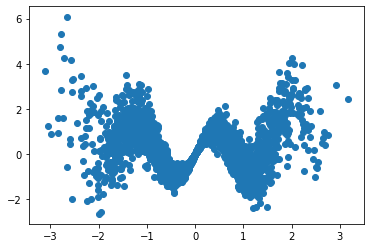

In [11]:
# Simulate data
num_obs = 3000
x, y = simulate_data(shape=(num_obs, 1), sd=.3)

# Plot data
plt.scatter(x, y)
plt.show()

### [`DenseVariational` Layer][1]

A `DenseVariational` layer is the analogous to the `Dense` layer
in a Bayesian model. It requires a prior and variational distribution.
This site provides an introduction to [automatic differentiation variational inference (ADVI)][2].

ELBO = $\text{E}_{q(\theta;\phi)}\left[\log p(\text{data}\mid\theta) + \log p(\theta) - \log q(\theta;\phi) \right]$
= $\text{E}_{q(\theta;\phi)}\left[\log p(\text{data}\mid\theta)\right] - \text{KL}(q(\theta)||p(\theta))$

The ELBO, an expectation, is approximated via one Monte Carlo sample from the variational
distribution (or guide) $q(\theta; \phi)$. The guide parameters $\phi$ are learned to 
maximize ELBO. 

For numerical stability, it is typical to optimize the ELBO normalized by the inverse
of the number of observations. It is possible to compute the log likelihood based
on mini batches (as in stochastic gradient descent). The `kl_weight` argument scales
the KL divergence term ($\text{KL}(q(\theta)||p(\theta))$) by the inverse 
of the number of observations for consistency when using mini batches.

[1]: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/layers/dense_variational_v2.py
[2]: https://luiarthur.github.io/statorial/varinf/introvi/

In [12]:
tf.random.set_seed(0)

go_bayesian = True

if go_bayesian:
    # Bayesian model
    model = tf.keras.Sequential([
        tfp.layers.DenseVariational(8,
                                    make_default_dense_guide,
                                    make_default_dense_prior,
                                    activation='sigmoid',
                                    kl_weight=1/num_obs),
        tfp.layers.DenseVariational(2,
                                    make_default_dense_guide,
                                    make_default_dense_prior,
                                    kl_weight=1/num_obs),
        tfp.layers.DistributionLambda(lambda t:
            # NOTE: `t[:, :1] != t[:, 0]` and `t[:, 1:] != t[:, 1]`.
            # This will be clear by inspecting the shapes.
            tfd.Normal(t[..., :1], centered_softplus(t[..., 1:]))
        )
    ])
else:
    # Model
    reg = tf.keras.regularizers.l2(0)
    act = 'sigmoid'
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, kernel_regularizer=reg, activation=act),
        tf.keras.layers.Dense(2, kernel_regularizer=reg),
        tfp.layers.DistributionLambda(lambda t:
            tfd.Normal(t[:, :1], centered_softplus(t[:, 1:]))
        )
    ])
    
model(x);

In [13]:
if go_bayesian:
    opt = tf.keras.optimizers.Adam(.1)
    model.compile(optimizer=opt, loss=neg_loglike)
else:
    opt = tf.keras.optimizers.Adam(.1)
    model.compile(optimizer=opt, loss=neg_loglike)

In [14]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari multiple                  32        
_________________________________________________________________
dense_variational_1 (DenseVa multiple                  36        
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit the model
if go_bayesian:
    history = model.fit(x, y, epochs=500, batch_size=512)
else: 
    history = model.fit(x, y, epochs=100, batch_size=512)

Train on 3000 samples
Epoch 1/500
3000/3000 [==============================] - 1s 432us/sample - loss: 3.2811
Epoch 2/500
3000/3000 [==============================] - 0s 5us/sample - loss: 3.5231
Epoch 3/500
3000/3000 [==============================] - 0s 7us/sample - loss: 2.1018
Epoch 4/500
3000/3000 [==============================] - 0s 7us/sample - loss: 2.4515
Epoch 5/500
3000/3000 [==============================] - 0s 7us/sample - loss: 2.6579
Epoch 6/500
3000/3000 [==============================] - 0s 7us/sample - loss: 2.4942
Epoch 7/500
3000/3000 [==============================] - 0s 9us/sample - loss: 2.4150
Epoch 8/500
3000/3000 [==============================] - 0s 7us/sample - loss: 2.4659
Epoch 9/500
3000/3000 [==============================] - 0s 8us/sample - loss: 2.4228
Epoch 10/500
3000/3000 [==============================] - 0s 7us/sample - loss: 2.2663
Epoch 11/500
3000/3000 [==============================] - 0s 7us/sample - loss: 2.1681
Epoch 12/500
3000/3000 [====

3000/3000 [==============================] - 0s 7us/sample - loss: 1.3249
Epoch 95/500
3000/3000 [==============================] - 0s 6us/sample - loss: 1.3210
Epoch 96/500
3000/3000 [==============================] - 0s 7us/sample - loss: 1.3149
Epoch 97/500
3000/3000 [==============================] - 0s 6us/sample - loss: 1.3143
Epoch 98/500
3000/3000 [==============================] - 0s 6us/sample - loss: 1.3209
Epoch 99/500
3000/3000 [==============================] - 0s 8us/sample - loss: 1.3160
Epoch 100/500
3000/3000 [==============================] - 0s 7us/sample - loss: 1.3053
Epoch 101/500
3000/3000 [==============================] - 0s 8us/sample - loss: 1.2975
Epoch 102/500
3000/3000 [==============================] - 0s 8us/sample - loss: 1.3089
Epoch 103/500
3000/3000 [==============================] - 0s 13us/sample - loss: 1.2844
Epoch 104/500
3000/3000 [==============================] - 0s 13us/sample - loss: 1.2959
Epoch 105/500
3000/3000 [========================

3000/3000 [==============================] - 0s 8us/sample - loss: 0.5598
Epoch 187/500
3000/3000 [==============================] - 0s 9us/sample - loss: 0.5504
Epoch 188/500
3000/3000 [==============================] - 0s 8us/sample - loss: 0.5572
Epoch 189/500
3000/3000 [==============================] - 0s 8us/sample - loss: 0.5477
Epoch 190/500
3000/3000 [==============================] - 0s 9us/sample - loss: 0.5536
Epoch 191/500
3000/3000 [==============================] - 0s 13us/sample - loss: 0.5514
Epoch 192/500
3000/3000 [==============================] - 0s 12us/sample - loss: 0.5586
Epoch 193/500
3000/3000 [==============================] - 0s 11us/sample - loss: 0.5522
Epoch 194/500
3000/3000 [==============================] - 0s 11us/sample - loss: 0.5448
Epoch 195/500
3000/3000 [==============================] - 0s 14us/sample - loss: 0.5512
Epoch 196/500
3000/3000 [==============================] - 0s 13us/sample - loss: 0.5701
Epoch 197/500
3000/3000 [===============

3000/3000 [==============================] - 0s 5us/sample - loss: 0.5353
Epoch 279/500
3000/3000 [==============================] - 0s 6us/sample - loss: 0.5373
Epoch 280/500
3000/3000 [==============================] - 0s 7us/sample - loss: 0.5228
Epoch 281/500
3000/3000 [==============================] - 0s 6us/sample - loss: 0.5198
Epoch 282/500
3000/3000 [==============================] - 0s 6us/sample - loss: 0.5304
Epoch 283/500
3000/3000 [==============================] - 0s 6us/sample - loss: 0.5328
Epoch 284/500
3000/3000 [==============================] - 0s 8us/sample - loss: 0.5285
Epoch 285/500
3000/3000 [==============================] - 0s 13us/sample - loss: 0.5331
Epoch 286/500
3000/3000 [==============================] - 0s 12us/sample - loss: 0.5267
Epoch 287/500
3000/3000 [==============================] - 0s 12us/sample - loss: 0.5190
Epoch 288/500
3000/3000 [==============================] - 0s 13us/sample - loss: 0.5199
Epoch 289/500
3000/3000 [=================

3000/3000 [==============================] - 0s 6us/sample - loss: 0.5351
Epoch 371/500
3000/3000 [==============================] - 0s 6us/sample - loss: 0.5350
Epoch 372/500
3000/3000 [==============================] - 0s 5us/sample - loss: 0.5141
Epoch 373/500
3000/3000 [==============================] - 0s 6us/sample - loss: 0.5300
Epoch 374/500
3000/3000 [==============================] - 0s 6us/sample - loss: 0.5232
Epoch 375/500
3000/3000 [==============================] - 0s 6us/sample - loss: 0.5373
Epoch 376/500
3000/3000 [==============================] - 0s 7us/sample - loss: 0.5391
Epoch 377/500
3000/3000 [==============================] - 0s 12us/sample - loss: 0.5206
Epoch 378/500
3000/3000 [==============================] - 0s 14us/sample - loss: 0.5135
Epoch 379/500
3000/3000 [==============================] - 0s 13us/sample - loss: 0.5145
Epoch 380/500
3000/3000 [==============================] - 0s 13us/sample - loss: 0.5282
Epoch 381/500
3000/3000 [=================

3000/3000 [==============================] - 0s 6us/sample - loss: 0.5232
Epoch 463/500
3000/3000 [==============================] - 0s 6us/sample - loss: 0.5087
Epoch 464/500
3000/3000 [==============================] - 0s 7us/sample - loss: 0.5056
Epoch 465/500
3000/3000 [==============================] - 0s 6us/sample - loss: 0.5074
Epoch 466/500
3000/3000 [==============================] - 0s 7us/sample - loss: 0.5085
Epoch 467/500
3000/3000 [==============================] - 0s 14us/sample - loss: 0.5196
Epoch 468/500
3000/3000 [==============================] - 0s 13us/sample - loss: 0.5153
Epoch 469/500
3000/3000 [==============================] - 0s 12us/sample - loss: 0.5245
Epoch 470/500
3000/3000 [==============================] - 0s 13us/sample - loss: 0.5120
Epoch 471/500
3000/3000 [==============================] - 0s 13us/sample - loss: 0.5287
Epoch 472/500
3000/3000 [==============================] - 0s 12us/sample - loss: 0.5179
Epoch 473/500
3000/3000 [===============

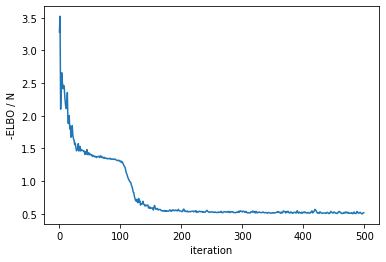

In [16]:
plt.plot(history.history['loss'])
plt.xlabel('iteration')
plt.ylabel('-ELBO / N')
plt.show()

In [17]:
# Make predictions at new locations
x_new = np.linspace(-4, 4, 100).reshape(-1, 1)

if go_bayesian:
    preds = np.stack([model.predict(x_new).squeeze() for _ in trange(32)], axis=1)
    preds_mean = preds.mean(1)
    preds_lower = np.quantile(preds, .025, 1)
    preds_upper = np.quantile(preds, .975, 1)
else:
    # preds_mean = model.predict(x_new)
    preds = np.stack([model.predict(x_new).squeeze() for _ in trange(32)], axis=1)
    preds_mean = preds.mean(1)
    preds_lower = np.quantile(preds, .025, 1)
    preds_upper = np.quantile(preds, .975, 1)

100%|██████████| 32/32 [00:02<00:00, 11.81it/s]


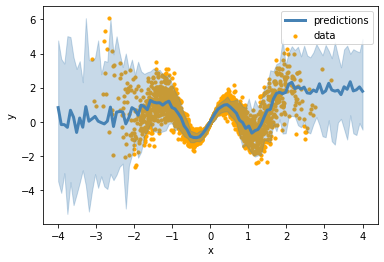

In [18]:
# Plot x vs y
plt.plot(x_new.squeeze(), preds_mean, label='predictions', zorder=2, lw=3, c='steelblue')
plt.fill_between(x_new.squeeze(), preds_lower, preds_upper, color='steelblue', alpha=.3, zorder=2)
plt.scatter(x.squeeze(), y.squeeze(), label='data', zorder=1, c='orange', s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [19]:
y_new = simulate_data(x_new, sd=.3)[1].squeeze()
np.mean((preds_lower < y_new) & (y_new < preds_upper))


0.82